# Предсказание IC50. Комбинация 2d и 1d интерпретации молекулы

## Подготовка данных

Установим и импортируем необходимые библиотеки

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 20.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

Загрузим датасет и посмотрим, что из себя представляют данные

In [4]:
df = pd.read_excel("19_35000.xlsx")
df.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [5]:
df = df[["SMILES", "IC50"]]
df.head()

,SMILES,IC50
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000015
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.000016
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000033
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000032
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.000041


Вычислим значение pIC50:

image.png

In [6]:
df['pIC50'] = -np.log10(df['IC50'])
df.head()

,SMILES,IC50,pIC50
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000015,4.838632
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.000016,4.798603
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000033,4.476254
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000032,4.492144
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.000041,4.381952


Теперь посмотрим, как распределены значения pIC50

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-3.5029185 , -3.50121765, -3.49951681, ...,  4.99790315,
         4.999604  ,  5.00130484]),
 <BarContainer object of 5000 artists>)

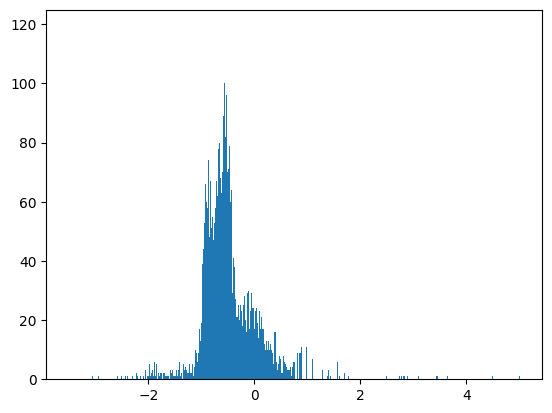

In [6]:
plt.hist(df['pIC50'], bins=5000)

In [7]:
mean = df['pIC50'].mean()
std = df['pIC50'].std()

print('среднее значение: ', mean)
print('стандартное отклонение: ', std)

среднее значение:  -0.45157586501862673
стандартное отклонение:  0.6084189179769062


Посмотрим распрделение по длине молекулы и, если необходимо, избавимся от выбросов.

array([[<Axes: title={'center': '0'}>]], dtype=object)

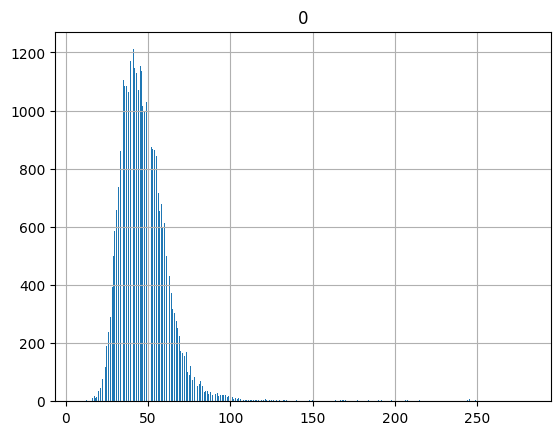

In [8]:
smiles_len = pd.DataFrame([len(sm) for sm in df["SMILES"]])
smiles_len.hist(bins=500)

In [9]:
np.percentile(smiles_len, 99)

99.0

In [9]:
df = df[df["SMILES"].apply(lambda x: len(x) < 100)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36015 entries, 0 to 36376
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  36015 non-null  object 
 1   IC50    36015 non-null  float64
 2   pIC50   36015 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


Теперь посмотрим, есть ли в датасете повторяющиеся молекулы и, если есть, посмотрим, какие значения pIC50 они принимают

In [10]:
smiles_dict = dict()
for i in range(len(df)):
  mol = df.iloc[i]['SMILES']
  if mol in smiles_dict:
    smiles_dict[mol].append(df.iloc[i]['pIC50'])
  else:
    smiles_dict[mol] = [df.iloc[i]['pIC50']]

for smile in smiles_dict:
  if len(smiles_dict[smile]) > 1:
    print(smiles_dict[smile])

[4.055024091587952, 4.309803919971486]
[3.806360678077417, -2.1936699079012625]
[3.751475014975931, -0.3830969299490942]
[4.728158393463501, 0.5228787452803376]
[4.546681659952962, 1.0, -1.559343951032151]
[1.778139958873903, 0.6989700043360187]
[3.1294404321464437, 3.2242585189435786]
[2.621625722406749, 2.3010299956639813]
[2.5681057555906204, 2.5681057555906204]
[2.154901959985743, 1.8239087409443189, 0.9706162223147904]
[1.2839966563652008, 0.9318141382538383]
[1.0, 0.045757490560675115, -0.0, -1.130333768495006]
[1.0, -0.1734776434529946, -0.9867717342662449]
[0.7878123955960422, 0.43889861635094407]
[0.6989700043360187, -1.4771212547196624]
[0.6989700043360187, 0.6989700043360187]
[0.6989700043360187, -0.0]
[0.6989700043360187, -0.6720978579357175]
[0.6882461389442457, -0.0]
[0.47237009912866135, -0.6698745024898025]
[0.41793663708829126, -1.2825768007092173]
[0.33629907461035186, -0.7634279935629373]
[0.24412514432750865, 0.040481623027001735]
[0.23507701535011155, 0.19314197048

Удалим все SMILES, у которых существуют пары значений pIC50, отличающихся друг от друга более, чем на значение std.

In [11]:
smiles_to_drop = set()

for smile in smiles_dict:
  arr = smiles_dict[smile]
  for i in range(len(arr) - 1):
    for j in range(i, len(arr)):
      if abs(arr[i] - arr[j]) > std:
        smiles_to_drop.add(smile)
        break

print(len(smiles_to_drop))
smiles_to_drop

35


{'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@@]2(C)O)c3ccco3',
 'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@]2(F)C)c3c(OC)cc(OC)cc3OC',
 'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@]2(F)C)c3ccc(cc3)OC',
 'C1CN(C)CCN1CCCN2c(cccc3)c3Sc(c24)ccc(Cl)c4',
 'C1COCCN1CC(=O)O[C@H]2C[C@H](CC3)C(C)(C)[C@@]23C',
 'C1C[C@H](C2)C(C)(C)C(=O)[C@@]12C',
 'CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C(=O)O)OC(CC)CC',
 'CC(=O)N[C@H]([C@H](C1)N)[C@H](OC(CC)CC)C=C1C(=O)OCC',
 'CC(=O)N[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C',
 'CC(=O)Nc(c1)ccc(c12)oc(n2)-c(ccn3)cc3C(=O)N4CCN(CC4)[C@@H](c5nnn(n5)C)c6ccc(F)cc6',
 'CC(=O)Nc(c1)ccc(c12)oc(n2)-c(ccn3)cc3C(=O)N4CCN(CC4)[C@H](c5nnn(n5)C)c6ccccc6',
 'CC1(C)[C@@H](CC2)CC(\\[C@]12C)=N/CCCCCCC\\N=C(\\[C@@]34C)C[C@H](C3(C)C)CC4',
 'CC1(C)[C@H](CC2)CC(\\[C@@]12C)=N/CCOC(=O)CCC(=O)OCC\\N=C(\\[C@]34C)C[C@@H](C3(C)C)CC4',
 'CCCC[C@H](NC(=O)C)[C@@H]([C@@H](C1)N=C(N)N)C[C@@H]1C(=O)O',
 'COc(cc1)c(OC)cc1Cc2nccc(c23)cc(OC)c(c3)OC',
 'COc(cc1)ccc1C\\N=C\\2C[C@@H](CC3)C(C)(C)[C@@]23C',
 '

In [12]:
df = df[df["SMILES"].apply(lambda x: not(x in smiles_to_drop))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35936 entries, 0 to 36376
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  35936 non-null  object 
 1   IC50    35936 non-null  float64
 2   pIC50   35936 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


## Работа с представлением молекулы

В данном ноутбуке мы рассмотрим комбинацию двух представлений молекулы.

- **MACCS keys fingerprint**

  MACCS Keys представляют собой бинарный вектор из 166 битов, где каждый бит представляет наличие или отсутствие конкретного химического или структурного фрагмента в молекуле.

- **Morgan's fingerprint**

  Учитывает не только наличие конкретных фрагментов, но и их окружение в молекуле, что позволяет учитывать более сложные химические взаимодействия.



In [13]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

def MACCKeys_fp(mol):
    mol = Chem.MolFromSmiles(mol)
    bit_vec = np.zeros((1,), np.int16)
    DataStructs.ConvertToNumpyArray(
        AllChem.GetMACCSKeysFingerprint(mol), bit_vec)

    return bit_vec

def morgan_fp(mol, radius=3, nBits=1024):
    mol = Chem.MolFromSmiles(mol)
    bit_vec = np.zeros((1,), np.int16)
    DataStructs.ConvertToNumpyArray(
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits), bit_vec)

    return bit_vec

In [14]:
macckeys = pd.DataFrame.from_records(df["SMILES"].apply(lambda x: MACCKeys_fp(x)), columns=[f'MACCKey_id_{i}' for i in range(167)])
macckeys.head()

,MACCKey_id_0,MACCKey_id_1,MACCKey_id_2,MACCKey_id_3,MACCKey_id_4,MACCKey_id_5,MACCKey_id_6,MACCKey_id_7,MACCKey_id_8,MACCKey_id_9,...,MACCKey_id_157,MACCKey_id_158,MACCKey_id_159,MACCKey_id_160,MACCKey_id_161,MACCKey_id_162,MACCKey_id_163,MACCKey_id_164,MACCKey_id_165,MACCKey_id_166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0


In [15]:
radius = 3
nBits = 1024

morgan = pd.DataFrame.from_records(df["SMILES"].apply(lambda x: morgan_fp(x, radius, nBits)), columns=[f'Morgan_id_{i}' for i in range(nBits)])
morgan.head()

,Morgan_id_0,Morgan_id_1,Morgan_id_2,Morgan_id_3,Morgan_id_4,Morgan_id_5,Morgan_id_6,Morgan_id_7,Morgan_id_8,Morgan_id_9,...,Morgan_id_1014,Morgan_id_1015,Morgan_id_1016,Morgan_id_1017,Morgan_id_1018,Morgan_id_1019,Morgan_id_1020,Morgan_id_1021,Morgan_id_1022,Morgan_id_1023
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [24]:
merged_fp = pd.concat([macckeys, morgan], axis=1)
merged_fp.head()

,MACCKey_id_0,MACCKey_id_1,MACCKey_id_2,MACCKey_id_3,MACCKey_id_4,MACCKey_id_5,MACCKey_id_6,MACCKey_id_7,MACCKey_id_8,MACCKey_id_9,...,Morgan_id_1014,Morgan_id_1015,Morgan_id_1016,Morgan_id_1017,Morgan_id_1018,Morgan_id_1019,Morgan_id_1020,Morgan_id_1021,Morgan_id_1022,Morgan_id_1023
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Подготовка датасета

In [25]:
from torch.utils.data import Dataset

class MolDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()
        self.y = torch.from_numpy(y.values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

## Обучение на разных моделях

In [22]:
from torch.utils.data import DataLoader

class Trainer():
    def __init__(self, net, dataset,
                 loss_f,
                 learning_rate=1e-3,
                 epoch_amount = 100,
                 epoch_eval_period = 10,
                 batch_size=16,
                 early_stopping=25,
                 device='cpu',
                 optim=torch.optim.Adam,
                 scheduler=None, permutate=True):

        self.dataset = dataset

        self.start_model = net
        self.best_model = net

        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.epoch_eval_period = epoch_eval_period
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        self.device = device
        self.loss_f = loss_f
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):
        Model = self.start_model

        device = torch.device(self.device)

        Model.to(device)

        optimizer = self.optim(params=Model.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train_dataset = self.dataset(X_train, y_train)
        val_dataset = self.dataset(X_test, y_test)

        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        best_val = float('inf')
        best_epoch = -1

        for epoch in range(self.epoch_amount):
            mean_loss = 0
            batch_n = 0
            Model.train()

            for batch_X, target in train:
                optimizer.zero_grad()

                batch_X = batch_X.to(device)
                target = target.to(device)

                predicted_values = Model(batch_X).view(-1)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)

            if epoch % self.epoch_eval_period == 0 or epoch == self.epoch_amount - 1:
              print(f'epoch {epoch}: ')
              print(f'Train_loss: {mean_loss}')

            mean_loss = 0
            batch_n = 0
            Model.eval()

            with torch.no_grad():
                for batch_X, target in val:
                    batch_X = batch_X.to(device)
                    target = target.to(device)

                    predicted_values = Model(batch_X).view(-1)
                    loss = self.loss_f(predicted_values, target)

                    mean_loss += float(loss)
                    batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)

            if epoch % self.epoch_eval_period == 0 or epoch == self.epoch_amount - 1:
              print(f'Val_loss: {mean_loss}')
              print()

            if (mean_loss < best_val):
                best_val = mean_loss
                best_epoch = epoch
                self.best_model = Model
            elif (epoch - best_epoch > self.early_stopping):
                print(f'{self.early_stopping} эпох без улучшения. Останавливаем обучение.')
                break
            if self.scheduler is not None:
                scheduler.step()

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged_fp, df['pIC50'], test_size=0.2, random_state=33)

### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

predicted = lin_reg_model.predict(X_test)
r2 = r2_score(y_test, predicted)
r2

-2.390120744526817e+21

### Catboost

In [30]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.1 MB/s eta 0:00:00


In [31]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

predicted = cat_model.predict(X_test)
r2 = r2_score(y_test, predicted)

Learning rate set to 0.069605
0:	learn: 0.5910533	total: 219ms	remaining: 3m 38s
1:	learn: 0.5868060	total: 331ms	remaining: 2m 45s
2:	learn: 0.5833102	total: 450ms	remaining: 2m 29s
3:	learn: 0.5798903	total: 561ms	remaining: 2m 19s
4:	learn: 0.5768607	total: 681ms	remaining: 2m 15s
5:	learn: 0.5739818	total: 816ms	remaining: 2m 15s
6:	learn: 0.5713505	total: 904ms	remaining: 2m 8s
7:	learn: 0.5689483	total: 1.05s	remaining: 2m 10s
8:	learn: 0.5666766	total: 1.26s	remaining: 2m 18s
9:	learn: 0.5641780	total: 1.4s	remaining: 2m 18s
10:	learn: 0.5621547	total: 1.53s	remaining: 2m 17s
11:	learn: 0.5603218	total: 1.65s	remaining: 2m 15s
12:	learn: 0.5586034	total: 1.77s	remaining: 2m 14s
13:	learn: 0.5566862	total: 1.91s	remaining: 2m 14s
14:	learn: 0.5552672	total: 2.02s	remaining: 2m 12s
15:	learn: 0.5537669	total: 2.15s	remaining: 2m 12s
16:	learn: 0.5524653	total: 2.27s	remaining: 2m 11s
17:	learn: 0.5513278	total: 2.38s	remaining: 2m 9s
18:	learn: 0.5501410	total: 2.49s	remaining: 2m

0.3453673578204902

In [32]:
r2

0.3453673578204902

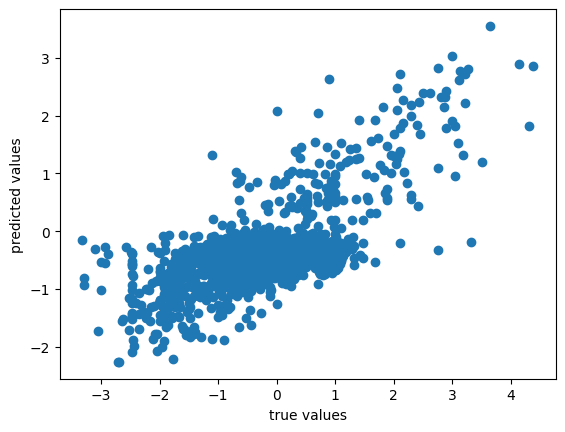

In [33]:
plt.scatter(y_test, predicted)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.show()

### Decision Tree

In [34]:
from sklearn import tree

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

predicted = tree_model.predict(X_test)
r2 = r2_score(y_test, predicted)
r2

-0.23676496694098104

### Linear Layers

In [36]:
import torch.nn as nn

ReLU = nn.ReLU()

class LinearLayers(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayers, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, out_features)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = ReLU(self.fc3(x))
        x = self.fc4(x)

        return x

In [39]:
in_features = len(X_train.columns)
out_features = 1

net = LinearLayers(in_features, out_features)

params = {
    'dataset': MolDataset,
    'net': net,
    'loss_f': nn.MSELoss(),
    'learning_rate': 2e-5,
    'early_stopping': 25,
    'epoch_amount': 300,
    'epoch_eval_period': 5,
    'optim': torch.optim.Adagrad,
    'batch_size': 32,
}

In [40]:
clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

epoch 0: 
Train_loss: 0.4267798459801711
Val_loss: 0.39356736540794374

epoch 5: 
Train_loss: 0.3427286627676516
Val_loss: 0.354860698249605

epoch 10: 
Train_loss: 0.3398530431033772
Val_loss: 0.3523631699548827

epoch 15: 
Train_loss: 0.33742892839951033
Val_loss: 0.350302461915546

epoch 20: 
Train_loss: 0.3353250979821926
Val_loss: 0.34845453805393645

epoch 25: 
Train_loss: 0.3332598691141115
Val_loss: 0.3467476854390568

epoch 30: 
Train_loss: 0.3315156797347
Val_loss: 0.3451064299212562

epoch 35: 
Train_loss: 0.3298765762944243
Val_loss: 0.3435103470749325

epoch 40: 
Train_loss: 0.3279999024892543
Val_loss: 0.34192064152823554

epoch 45: 
Train_loss: 0.3265258231851893
Val_loss: 0.34041559980975256

epoch 50: 
Train_loss: 0.32491730908563854
Val_loss: 0.33902385155359904

epoch 55: 
Train_loss: 0.3233598208881591
Val_loss: 0.33771006408664916

epoch 60: 
Train_loss: 0.32180750309111544
Val_loss: 0.33645092238982516

epoch 65: 
Train_loss: 0.3208420034435819
Val_loss: 0.3352469

In [43]:
predicted = clf.predict(torch.from_numpy(X_test.values).float())
r2 = r2_score(y_test, predicted.detach().numpy())
r2

0.16363044070967214

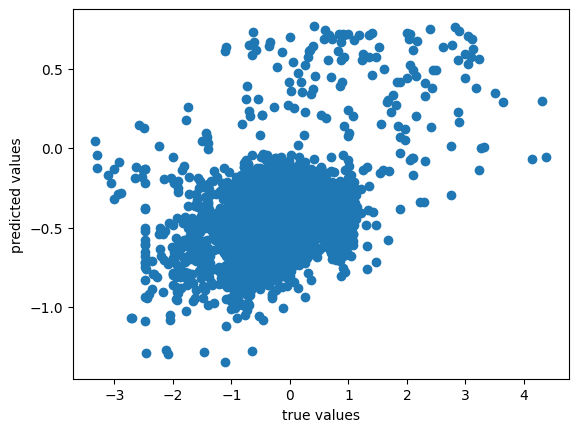

In [45]:
plt.scatter(y_test, predicted.detach().numpy())
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.show()

## NLP

In [152]:
class SmilesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_list())
        self.y = torch.from_numpy(y.values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

### 1d CNN + bidirectional GRU

In [161]:
class CNN_GRU(nn.Module):
    def __init__(self, out_features,
                 vocab_size, embed_size,
                 kernel_size, hidden_dim, num_layers=1):
        super(CNN_GRU, self).__init__()

        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)

        self.conv1d = nn.Conv1d(in_channels=embed_size, out_channels=64, kernel_size=kernel_size)

        self.gru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=True)

        self.fc = nn.Linear(hidden_dim*2, out_features)

    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.permute(0, 2, 1)

        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x, _ = self.gru(x)
        x = torch.cat((x[:, -1, :hidden_dim], x[:, 0, hidden_dim:]), dim=1)

        x = self.fc(x)

        return x

In [144]:
vocab = set()
vocab.add(' ')
for smile in df['SMILES']:
  for s in smile:
    vocab.add(s)

In [131]:
vocab

{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 '@',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 'Z',
 '[',
 '\\',
 ']',
 'a',
 'c',
 'e',
 'i',
 'l',
 'n',
 'o',
 'r',
 's'}

In [145]:
tokens = dict()
token = 0
for s in sorted(vocab):
  tokens[s] = token
  token += 1
tokens

{' ': 0,
 '#': 1,
 '(': 2,
 ')': 3,
 '+': 4,
 '-': 5,
 '.': 6,
 '/': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 '=': 17,
 '@': 18,
 'B': 19,
 'C': 20,
 'F': 21,
 'H': 22,
 'I': 23,
 'N': 24,
 'O': 25,
 'P': 26,
 'S': 27,
 'Z': 28,
 '[': 29,
 '\\': 30,
 ']': 31,
 'a': 32,
 'c': 33,
 'e': 34,
 'i': 35,
 'l': 36,
 'n': 37,
 'o': 38,
 'r': 39,
 's': 40}

In [146]:
tokenized_smiles = df["SMILES"].apply(lambda x: np.array([tokens[x[i]] if i < len(x) else 0 for i in range(99)], dtype='int64'))
tokenized_smiles

0        [29, 22, 31, 30, 24, 17, 20, 2, 24, 3, 30, 24,...
1        [25, 17, 20, 2, 25, 3, 20, 8, 17, 20, 29, 20, ...
2        [20, 17, 20, 20, 2, 17, 25, 3, 24, 29, 20, 18,...
3        [20, 20, 2, 17, 25, 3, 24, 29, 20, 18, 22, 31,...
4        [25, 17, 20, 2, 25, 3, 33, 8, 33, 2, 25, 3, 33...
                               ...                        
36369    [20, 20, 2, 17, 25, 3, 24, 33, 2, 33, 33, 8, 3...
36371    [20, 20, 2, 17, 25, 3, 24, 33, 2, 33, 2, 33, 8...
36373    [20, 20, 2, 17, 25, 3, 24, 33, 2, 33, 33, 8, 3...
36375    [24, 20, 20, 20, 20, 2, 17, 25, 3, 24, 33, 2, ...
36376    [20, 20, 2, 17, 25, 3, 24, 29, 20, 18, 22, 31,...
Name: SMILES, Length: 35936, dtype: object

In [153]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_smiles, df['pIC50'], test_size=0.2, random_state=33)

In [154]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [162]:
out_features = 1
vocab_size = len(vocab)
embed_size = 512
kernel_size = 7
hidden_dim = 128

net = CNN_GRU(out_features, vocab_size, embed_size, kernel_size, hidden_dim)

params = {
    'dataset': SmilesDataset,
    'net': net,
    'loss_f': nn.MSELoss(),
    'learning_rate': 2e-5,
    'early_stopping': 25,
    'epoch_amount': 300,
    'epoch_eval_period': 5,
    'optim': torch.optim.Adagrad,
    'batch_size': 32,
    'device': device,
}

In [163]:
clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

epoch 0: 
Train_loss: 0.3536664641092431
Val_loss: 0.3638711707790693

epoch 5: 
Train_loss: 0.35014667859232596
Val_loss: 0.361484600438012

epoch 10: 
Train_loss: 0.34888831760580996
Val_loss: 0.3606170384420289

epoch 15: 
Train_loss: 0.34847993929937765
Val_loss: 0.360081965956423

epoch 20: 
Train_loss: 0.34771535185075575
Val_loss: 0.359681374794907

epoch 25: 
Train_loss: 0.3467392522564056
Val_loss: 0.359312520954344

epoch 30: 
Train_loss: 0.3468023854513985
Val_loss: 0.35903728504975635

epoch 35: 
Train_loss: 0.34685446964255695
Val_loss: 0.35882326831420264

epoch 40: 
Train_loss: 0.34628578933480053
Val_loss: 0.3586794474389818

epoch 45: 
Train_loss: 0.3461767333218863
Val_loss: 0.3584718542628818

epoch 50: 
Train_loss: 0.34597496980919323
Val_loss: 0.35843402326107027

epoch 55: 
Train_loss: 0.34530903331032053
Val_loss: 0.3582206517457962

epoch 60: 
Train_loss: 0.3454457567103447
Val_loss: 0.35806146687931484

epoch 65: 
Train_loss: 0.3451674108427677
Val_loss: 0.3579

In [171]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [172]:
test_tensor = torch.tensor(X_test.to_list()).to(device)
predicted = clf.predict(test_tensor)
r2 = r2_score(y_test, predicted.cpu().detach().numpy())
r2

0.028843972568113108

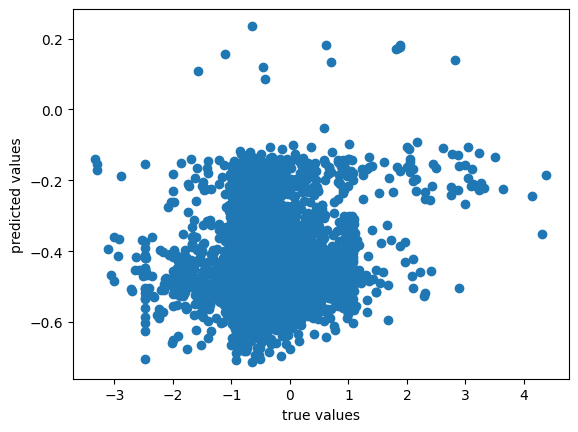

In [173]:
plt.scatter(y_test, predicted.cpu().detach().numpy())
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.show()